### How re-encoding a video with a different start frame changes the images, and causes differences in trackCircle

In [1]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper

In [ ]:
'''
verify:
[~] listGS output the 1st time should be the same
[~] listGS output should be different 2nd time
[x] writing lossless eliminates the pathology

demonstrate:
[~] instead of using guiview, read/write frames here

thoughts:
 - maybe this isn't as bad as we think: we'll just always keep the same
 anchor frame and copy a video each time before Add/Update Score options
 - to create intervals of interest, we can persist the frame indexes,
  while not messing with the vid itself
 - raw -> edit1; first edit to remove any filler frames w/o anything
  of interest. From then on, no more removing frames
 - if you absolutely need to clip out a frame interval; insert it into 
  eval db as a new video; with no tracking history
 
 notes:
  base directory = tmp/short2
  base5         = dec14/output5.proc1.proc1
  base5.proc1   = frames 0-9  (h264 encoded)
  base5.proc2   = frames 1-9  (h264 encoded)
  base5.proc3   = frames 0-9  (lossless encoding)
  base5.proc4   = frame  1-9  (lossless encoding)

'''

##### Verify that tracking is different on a diff videos

In [242]:
# load videos
data_path = 'data/misc/books/encoding-issue-1/'
# data_path = 'data/proc/tmp/short2/'
vid_fns = ['base5.proc1.avi', 'base5.proc2.avi',
           'base5.proc3.avi', 'base5.proc4.avi'
          ]
vid_paths = [data_path + fn for fn in vid_fns]

dfs = []
for vid_path in vid_paths:
    df = subprocEval(vid_path, algo_enum=0)
    dfs.append(df)

In [244]:
# encoded videos --------
# col0: vid1-data0-value, col1: vid2-data0-val, col2: diff of col0 - col1

col = 'track_data0_0'
[ (int(a),int(b), int(a-b)) for a,b in zip(dfs[0][col][1:], dfs[1][col])]

[(108, 108, 0),
 (117, 117, 0),
 (124, 125, -1),
 (133, 133, 0),
 (141, 142, -1),
 (153, 152, 1),
 (160, 161, -1),
 (172, 173, -1),
 (183, 183, 0)]

In [212]:
# lossless videos --------
# col0: vid1-data0-value, col1: vid2-data0-val, col2: diff of col0 - col1

col = 'track_data0_0'
tbl = [ (int(a),int(b), int(a-b)) for a,b in zip(dfs[2][col][1:], dfs[3][col])]
print 'max track diff: ', str(max([diff for a,b,diff in tbl]))
tbl

max track diff:  0


[(108, 108, 0),
 (118, 118, 0),
 (126, 126, 0),
 (134, 134, 0),
 (143, 143, 0),
 (153, 153, 0),
 (162, 162, 0),
 (174, 174, 0),
 (183, 183, 0)]

##### Check how the frames themselves differ

In [11]:
''' 
[x] import ImgDiff from test/utils.py
[x] read in frames
[x] compare diffs
[x] sum() pixel diffs correctly

'''

In [240]:
# for encoded vids
# proc1 start at frame0, proc2 starts at frame1

data_path = '../data/proc/tmp/short2/'
vid_fns = ['base5.proc1.avi', 'base5.proc2.avi']
d_frames = {}

for vid_fn in vid_fns:

    vid_path = data_path + vid_fn
    
    cam = cv2.VideoCapture(vid_path)
    
    frames = []
    
    while(cam.isOpened()):
        ret, frame = cam.read()
        if ret:
            frames.append(frame)
        else:
            break
            
    d_frames[vid_fn] = copy.deepcopy(frames)
    print len(frames)

10
9


In [241]:
f1 = d_frames['base5.proc1.avi']
f2 = d_frames['base5.proc2.avi']
_ = f1.pop(0)
d_frames.keys()

['base5.proc1.avi', 'base5.proc2.avi']

##### typical "adjacent" frame diff

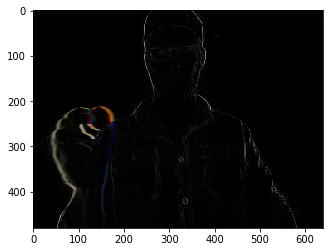

In [126]:
#this is "good" - these are two consecutive frames within same video;
# the diff shows where motion is occuring
plt.imshow(cv2.absdiff(f1[0], f1[1]))

##### typical different encoded video diff

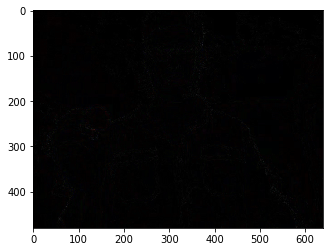

In [127]:
ind = 0

img_d = cv2.absdiff(f1[ind], f2[ind])
# print 'total number diff: ', str(sum(sum(sum(img_d))))

# here's an un-informative img with the diffs, too faint to see
plt.imshow(img_d)

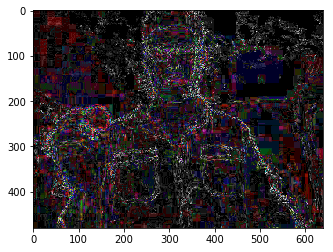

In [187]:
# multiply all diffs by 'factor' to accentuate the diffs
factor = 20
plt.imshow(img_d * factor)

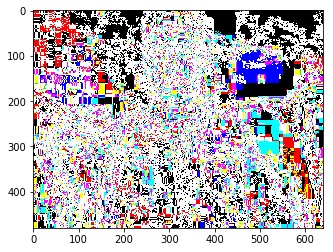

In [118]:
# this shows which color is different b/w the encodings,
# setting any difference in that color channel to maxmium (255) diff
color_specific_diff = np.where(img_d[:,:,:] > 0 , 255, 0)
plt.imshow(color_specific_diff)

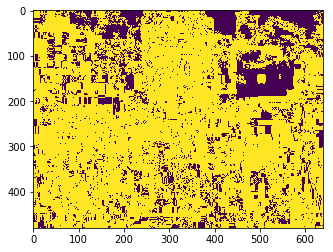

In [135]:
# show which pixels have any diff
# yellow = yes; blue = no
masks = []
for i in range(3):
    masks.append(img_d[:,:,i] > 0)
mask_all = np.bitwise_or(masks[0], masks[1], masks[2])
plt.imshow(mask_all)

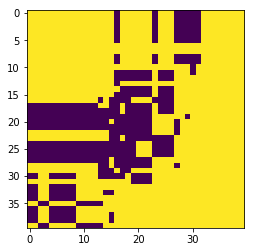

In [136]:
# same plot as above but a small portion
plt.imshow(mask_all[:40,:40])

channel i=0 max: 58


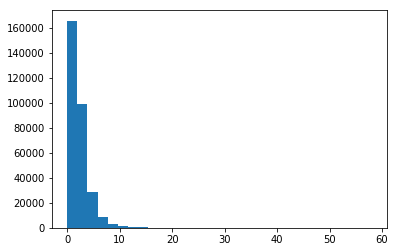

channel i=1 max: 58


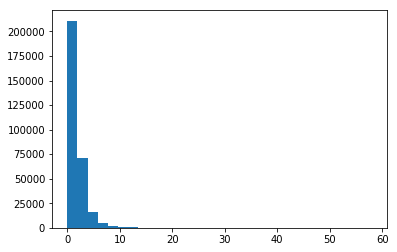

channel i=2 max: 58


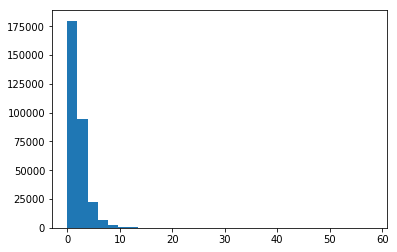

In [188]:
# view the distribution of the diffs for each color channel
for i in range(3):
    channel_i = img_d[:,:,i]
    print 'channel i=%s max: %i' % (str(i), max(np.ravel(channel_i)))
    plt.hist(np.ravel(channel_i), bins=30)
    plt.show()

#### Example of how to sum properly:
first convert to larger dtype, e.g. 'uint32', then iteratively sum

In [232]:
# clearly as we continue to sum, the numbers get smaller sometimes!
# it's because dtype=uint8 overflow!
print sum(img_d)
print '--------'
print sum(sum(img_d))
print '--------'
print sum(sum(sum(img_d)))

[[213 197 149]
 [217 197 137]
 [194 154 114]
 ...
 [  0 200   0]
 [ 31 227  47]
 [248 214  40]]
--------
[151 254  87]
--------
492


In [234]:
print img_d.dtype
base_img  = img_d.copy()
converted_img = base_img.astype('uint32', copy=True)
print converted_img.dtype

uint8
uint32


In [235]:
sum(converted_img)

array([[725, 453, 405],
       [729, 453, 393],
       [706, 410, 370],
       ...,
       [768, 456, 512],
       [799, 483, 559],
       [760, 470, 552]], dtype=uint32)

In [236]:
sum(sum(converted_img))

array([535959, 409342, 484951], dtype=uint32)

In [238]:
# as can be seen this does work
sum(sum(sum(converted_img)))

1430252